In [11]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model


image_folder = "Ukr"
east_path = "opencv_text_detection/frozen_east_text_detection.pb"
min_confidence = 0.5
width = 320
height = 320
model_path = 'C:/Models/Ukrainian_OCR_tf_2.1.h5'
model = load_model(model_path)


output_folder = "tmp"
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

In [12]:
from matplotlib import pyplot as plt


def show_image(image, title=None, conversion=cv2.COLOR_BGR2RGB, dpi=10):

    # Create a new figure with the specified dpi
    plt.figure(dpi=dpi)

    # Converts from one colour space to the other. this is needed as RGB
    # is not the default colour space for OpenCV
    image = cv2.cvtColor(image, conversion)

    # Show the image
    plt.imshow(image)

    # remove the axis / ticks for a clean looking image
    plt.xticks([])
    plt.yticks([])

    # if a title is provided, show it
    if title is not None:
        plt.title(title)

    plt.show()

In [13]:
def resize_image(image, max_size=960):
    height, width = image.shape[:2]

    if height > max_size or width > max_size:
        if height > width:
            new_height = max_size
            new_width = int((width * max_size) / height)
        else:
            new_width = max_size
            new_height = int((height * max_size) / width)
        return cv2.resize(image, (new_width, new_height))
    else:
        return image

In [14]:
def clear_border(image):
    top, bottom, left, right = 1, 1, 1, 1
    image_without_borders = image[top:-bottom, left:-right]

    image_with_border = cv2.copyMakeBorder(image_without_borders, 1, 1, 1, 1, cv2.BORDER_CONSTANT, value=[255, 255, 255])
    return image_with_border

In [15]:

def format_image(image):
    if image is None or not isinstance(image, np.ndarray) or len(image.shape) < 2:
        raise ValueError("Invalid input image.")

    if len(image.shape) == 2 or image.shape[2] == 1:
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    elif image.shape[2] > 3:
        image = image[:, :, :3]
    return image

In [16]:
def clear_background(image):
    formated = format_image(image)

    image_with_border = clear_border(formated)

    gray_image = cv2.cvtColor(image_with_border, cv2.COLOR_BGR2GRAY)

    # Apply GaussianBlur to reduce noise
    blurred_image = cv2.GaussianBlur(gray_image, (3, 3), 0)

    # Apply adaptive thresholding
    thresh = cv2.adaptiveThreshold(blurred_image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 27, 50)

    return thresh

In [17]:
def is_line_empty(line, threshold=0.03, gray_threshold=130):
    """
    Determine if a line contains text based on the number of non-white pixels.

    Args:
    line (numpy.ndarray): Image of the line.
    threshold (float): Threshold for the proportion of non-white pixels to consider a line as empty. Default is 0.01 (1%).
    gray_threshold (int): Gray level threshold to consider a pixel as non-white. Default is 200.

    Returns:
    bool: True if the line is empty, False otherwise.
    """

    non_white_pixels = np.count_nonzero(line < gray_threshold)
    total_pixels = line.size

    if non_white_pixels / total_pixels < threshold:
        return True
    else:
        return False

In [18]:
def apply_brightness_contrast(input_img, brightness = 0, contrast = 0):
    
    if brightness != 0:
        if brightness > 0:
            shadow = brightness
            highlight = 255
        else:
            shadow = 0
            highlight = 255 + brightness
        alpha_b = (highlight - shadow)/255
        gamma_b = shadow
        
        buf = cv2.addWeighted(input_img, alpha_b, input_img, 0, gamma_b)
    else:
        buf = input_img.copy()
    
    if contrast != 0:
        f = 131*(contrast + 127)/(127*(131-contrast))
        alpha_c = f
        gamma_c = 127*(1-f)
        
        buf = cv2.addWeighted(buf, alpha_c, buf, 0, gamma_c)

    return buf

im = cv2.imread('Ukr/Franko_page.jpg')
im = apply_brightness_contrast(im, contrast=40, brightness=20)
show_image(im)

In [19]:
from imutils import contours

def segment_words(image, p_image, file_name, line_number):
    converted = cv2.bitwise_not(p_image)

    blurred_image = cv2.GaussianBlur(converted, (5, 5), 0)

    # Apply morphological dilation to connect words
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 12))
    dilated = cv2.dilate(blurred_image, kernel, iterations=1)

    cnts = cv2.findContours(dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]


    words_images = []
    if len(cnts) > 0:
        cnts, _ = contours.sort_contours(cnts, method="left-to-right")

        for c in cnts:
            area = cv2.contourArea(c)
            if area > 10:
                x, y, w, h = cv2.boundingRect(c)
                ROI = image[y:y+h, x:x+w]
                words_images.append(ROI)

    return words_images



im = cv2.imread('tmp\\photo_2023-_page\\line_27.jpg')
p_im = clear_background(im)
im = segment_words(im, p_im, '', '')

for word in im:
    show_image(word)

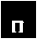

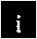

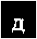

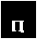

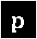

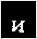

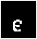

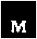

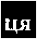

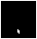

In [20]:
img_size = 32


def extract_letters(word_image, img_size):
    no_border = clear_border(word_image)
    _, otsu_threshold = cv2.threshold(no_border, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 3))
    dilated = cv2.dilate(otsu_threshold, kernel, iterations=1)

    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
    eroded = cv2.erode(dilated, kernel, iterations=1)

    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 5))
    dilated = cv2.dilate(eroded, kernel, iterations=1)

    cnts, _ = cv2.findContours(dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    image_copy = word_image.copy()
    image_copy = cv2.cvtColor(image_copy, cv2.COLOR_GRAY2BGR)
    letters = []

    cnts_sorted, _ = contours.sort_contours(cnts, method="left-to-right")

    # Process each contour, resize or pad the images
    for cont in cnts_sorted:
        x, y, w, h = cv2.boundingRect(cont)
        if h > 0 and w > 0:
            cv2.rectangle(image_copy, (x, y), (x + w, y + h), (0, 255, 0), 2)

            letter = word_image[y:y+h, x:x+w]

            thresh = cv2.adaptiveThreshold(letter, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 181, 40)

            if h > img_size or w > img_size:
                # Resize the letter image while keeping the aspect ratio
                aspect_ratio = min(float(w), float(h)) / max(float(w), float(h))

                if h > img_size:
                    h = img_size
                    w = int(aspect_ratio * h)
                else: # w > img_size
                    w = img_size
                    h = int(aspect_ratio * w)

                letter_processed = cv2.resize(thresh, (w, h), interpolation=cv2.INTER_AREA)

            # Calculate padding for the current letter
            pad_top = img_size - h
            pad_bottom = 2
            pad_left = (img_size - w) // 2
            pad_right = img_size - w - pad_left


            # Pad the letter image to match the maximum dimensions
            letter_processed = cv2.copyMakeBorder(thresh, pad_top, pad_bottom, pad_left, pad_right, cv2.BORDER_CONSTANT, value=0)
            letters.append(letter_processed)

    return letters



im = cv2.imread('tmp\\photo_2023-_page\\line_27\\word_6.jpg')
im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
letters = extract_letters(im, 32)

for letter in letters:
    show_image(letter)

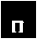

letter: п; probability: 0.9945397973060608


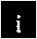

letter: і; probability: 0.9938076138496399


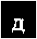

letter: д; probability: 0.9970826506614685


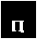

letter: п; probability: 0.9904229640960693


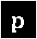

letter: р; probability: 0.9920141100883484


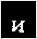

letter: и; probability: 0.9843477010726929


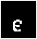

letter: є; probability: 0.9629616141319275


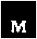

letter: м; probability: 0.9823300838470459


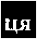

letter: щ; probability: 0.5488680005073547


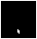

letter: ,; probability: 0.6331358551979065


In [21]:


def recognize_letter(letter_image, model, attempts=3, min_probability=0.2):
    letters = [
        'А','Б','В','Г','Ґ','Д','Е','Є','Ж','З','И','І','Ї','Й','К',
        'Л','М','Н','О','П','Р','С','Т','У','Ф','Х','Ц','Ч','Ш','Щ',
        'Ь','Ю','Я','а','б','в','г','ґ','д','е','є','ж','з','и','і',
        'ї','й','к','л','м','н','о','п','р','с','т','у','ф','х','ц',
        'ч','ш','щ','ь','ю','я','1','2','3','4','5','6','7','8','9',
        '0','№','%','@',',','.','?',':',';','"','!','(',')','-','\''
    ]

    for attempt in range(attempts):
        # Змінюємо розмір зображення літери до 32x32
        resized_letter = cv2.resize(letter_image, (32, 32), interpolation=cv2.INTER_AREA)

        blur_size = (3, 3)  # розмір ядра для гаусового блюру, можна змінювати за потреби
        blur_sigma = 0  # відхилення, якщо дорівнює 0, відхилення обчислюється автоматично
        letter_blured = cv2.GaussianBlur(resized_letter, blur_size, blur_sigma)

        # Перевіряємо кількість каналів у зображенні
        if len(letter_blured.shape) == 3:
            # Конвертуємо зображення у відтінки сірого, якщо воно кольорове
            gray_letter = cv2.cvtColor(letter_blured, cv2.COLOR_BGR2GRAY)
        else:
            gray_letter = letter_blured

        # Конвертуємо в float32 та нормалізуємо
        data = np.array(gray_letter, dtype=np.float32)
        data = np.expand_dims(data, axis=-1)
        data /= 255.0

        # Передбачаємо літеру за допомогою навченої моделі
        prediction = model.predict(np.array([data]))[0]
        predicted_index = np.argmax(prediction)
        probability = prediction[predicted_index]  # Отримуємо ймовірність передбаченого індексу
        predicted_letter = letters[predicted_index]  # Отримуємо передбачену літеру з масиву літер

        if probability >= min_probability:
            return predicted_letter, probability, predicted_index
        else:
            # Змінюємо зображення перед наступною спробою
            if attempt == 0:
                # Зменшення зображення
                scale_percent = 80
                width = int(letter_image.shape[1] * scale_percent / 100)
                height = int(letter_image.shape[0] * scale_percent / 100)
                dim = (width, height)
                letter_image = cv2.resize(letter_image, dim, interpolation=cv2.INTER_AREA)
            elif attempt == 1:
                # Збільшення зображення
                scale_percent = 120
                width = int(letter_image.shape[1] * scale_percent / 100)
                height = int(letter_image.shape[0] * scale_percent / 100)
                dim = (width, height)
                letter_image = cv2.resize(letter_image, dim, interpolation=cv2.INTER_AREA)
            elif attempt == 2:
                # Поворот на 180 градусів
                letter_image = cv2.rotate(letter_image, cv2.ROTATE_180)
        # Якщо тричі ймовірність залишається низькою, повертаємо "_"
    return "_", 0, -1

for letter in letters:
    show_image(letter)
    pre_letter, probability, predicted_index = recognize_letter(letter, model)
    print(f'letter: {pre_letter}; probability: {probability}')

In [22]:
import os
def save_image(folder_path, file_name, image):
    output_file = os.path.join(folder_path, file_name)
    cv2.imwrite(output_file, image)


In [ ]:
import cv2
from Page_to_lines import get_lines
from opencv_text_detection.text_detection import text_detection


# Assuming you have the other necessary functions defined above

for file_name in os.listdir(image_folder):
    if file_name.endswith(".jpg") or file_name.endswith(".png"):
        image_path = os.path.join(image_folder, file_name)
        print(f"Processing {image_path}")

        if "_page" in file_name:
            result = ''
            image = cv2.imread(image_path)
            
            # Resize the image before processing
            resized_image = resize_image(image)

            # Save the resized image, overwriting the original image
            cv2.imwrite(image_path, resized_image)
            
            lines = get_lines(image_path, kernel_size=17, sigma=3, theta=9, smooth_window_len=2, threshold=0.4, peak_min_distance=2)

            # Create a folder for the current image
            current_image_folder = os.path.join(output_folder, file_name[:-4])
            if not os.path.exists(current_image_folder):
                os.makedirs(current_image_folder)

            # Process each line and save it in the folder
            for line_idx, line in enumerate(lines):
                if not line.size == 0:  # Check if the line is not empty
                    p_line = clear_background(line)
                    if not is_line_empty(p_line):  # Check if the line contains text
                        words_images = segment_words(line, p_line, file_name, line_idx)
                        
                        # Create a folder for the current line
                        current_line_folder = os.path.join(current_image_folder, f"line_{line_idx}")
                        if not os.path.exists(current_line_folder):
                            os.makedirs(current_line_folder)

                        for word_idx, word_image in enumerate(words_images):

                            letters = extract_letters(word_image, 32)

                            # Create a folder for the current word
                            current_word_folder = os.path.join(current_line_folder, f"word_{word_idx}")
                            if not os.path.exists(current_word_folder):
                                os.makedirs(current_word_folder)
                                
                            letters_folder = os.path.join(output_folder, f"letters")
                            if not os.path.exists(letters_folder):
                                os.makedirs(letters_folder)
                            
                            # Save each letter in the folder
                            for letter_idx, letter_image in enumerate(letters):
                                save_image(current_word_folder, f"letter_{letter_idx}.jpg", letter_image)
                                
                                # Recognize the letter using the trained model                               

                                predicted_letter, probability, predicted_index = recognize_letter(letter_image, model)
                                result += predicted_letter
                                save_image(letters_folder, f"file_{file_name}_line_{line_idx}_word_{word_idx}_letter_{letter_idx}_prediction_{predicted_index}.jpg", letter_image)
                                print(f"Letter {letter_idx} is recognized as '{predicted_letter}' with probability {probability:.2f}")
                                
                            # Add space after each word
                            result += ' '
                            
                            # Save word image in the line folder
                            save_image(current_line_folder, f"word_{word_idx}.jpg", word_image)

                # Save line image in the image folder only if it's not empty
                if line.size > 0:
                    save_image(current_image_folder, f"line_{line_idx}.jpg", line)

            # Add space after each line
            result += ' '
            
            print(result)
        else:
            data, result_img = text_detection(image_path, east_path, min_confidence, width, height)
            save_image(output_folder, file_name, result_img)

print("Processing completed.")

Processing Ukr\2_page.jpg
x1= 0 , x2= 0 , Diff=  0
x1= 0 , x2= 8 , Diff=  8
x1= 8 , x2= 69 , Diff=  61
x1= 69 , x2= 107 , Diff=  38
x1= 107 , x2= 144 , Diff=  37
x1= 144 , x2= 182 , Diff=  38
x1= 182 , x2= 219 , Diff=  37
x1= 219 , x2= 255 , Diff=  36
x1= 255 , x2= 292 , Diff=  37
x1= 292 , x2= 329 , Diff=  37
x1= 329 , x2= 365 , Diff=  36
x1= 365 , x2= 374 , Diff=  9
true: 0.0
false: 0.04844603825136612
Letter 0 is recognized as 'А' with probability 0.81
Letter 1 is recognized as 'к' with probability 0.81
Letter 2 is recognized as 'т' with probability 0.51
Letter 3 is recognized as 'р' with probability 0.99
Letter 4 is recognized as 'а' with probability 0.62
Letter 5 is recognized as 'л' with probability 0.92
Letter 6 is recognized as 'ь' with probability 0.88
Letter 0 is recognized as 'е' with probability 0.95
Letter 1 is recognized as 'ф' with probability 0.93
Letter 2 is recognized as 'е' with probability 0.99
Letter 3 is recognized as 'т' with probability 0.59
Letter 4 is recogniz

KeyboardInterrupt: 

In [25]:
from Page_to_lines import get_lines, display_lines
import tempfile

def process_letter(letter_image, letter_idx, model):
    predicted_letter, probability, predicted_index = recognize_letter(letter_image, model)
    return predicted_letter

def process_word(word_image, file_name, line_idx, word_idx, model, img_size):
    result = ''
    letters = extract_letters(word_image, img_size)
    for letter_idx, letter_image in enumerate(letters):
        result += process_letter(letter_image, letter_idx, model)
    return result + ' '

def process_line(line, file_name, line_idx, model, img_size):
    result = ''
    if not line.size == 0:
        p_line = clear_background(line)
        if not is_line_empty(p_line):
            words_images = segment_words(line, p_line, file_name, line_idx)
            for word_idx, word_image in enumerate(words_images):
                result += process_word(word_image, file_name, line_idx, word_idx, model, img_size)
    return result + ' '

def process_image(image_path, model, img_size):
    result = ''

    image = cv2.imread(image_path)

    # Resize the image before processing
    resized_image = resize_image(image)

    # Save the resized image in a temporary file
    tmp_file_descriptor, tmp_file_name = tempfile.mkstemp(suffix='.jpg')
    os.close(tmp_file_descriptor)
    cv2.imwrite(tmp_file_name, resized_image)

    lines = get_lines(tmp_file_name, kernel_size=17, sigma=3, theta=9, smooth_window_len=3, threshold=0.3, peak_min_distance=2)

    os.remove(tmp_file_name)

    # The temporary file will be deleted when the context manager exits

    for line_idx, line in enumerate(lines):
        result += process_line(line, image_path, line_idx, model, img_size)

    return result.lower()

# Assuming you have the other necessary functions defined above

for file_name in os.listdir(image_folder):
    if file_name.endswith(".jpg") or file_name.endswith(".png"):
        image_path = os.path.join(image_folder, file_name)
        print(f"Processing {image_path}")

        result = process_image(image_path, model, 32)
        print(result.lower())

print("Processing completed.")


Processing Ukr\2_page.jpg
x1= 0 , x2= 0 , Diff=  0
x1= 0 , x2= 9 , Diff=  9
x1= 9 , x2= 70 , Diff=  61
x1= 70 , x2= 108 , Diff=  38
x1= 108 , x2= 145 , Diff=  37
x1= 145 , x2= 183 , Diff=  38
x1= 183 , x2= 220 , Diff=  37
x1= 220 , x2= 256 , Diff=  36
x1= 256 , x2= 293 , Diff=  37
x1= 293 , x2= 330 , Diff=  37
x1= 330 , x2= 366 , Diff=  36
x1= 366 , x2= 375 , Diff=  9
  актраль еф етив ний в лікуванні го_рих і хроніцних гепа_  ти_в рі3 н0ю №не_у (алкогольних, токсичних, вірусних),  жир_ в ої дитрофії ш цирозів печінки, для профілатик.и  захв о р юван ь печінки внасл;док шкі_ивого впливу різних  то ксинів ( алкоголь, жирна та го_ра їжа, напівфабрикати,  ко нсерванти), порушеннях режиму харчування (ді_а),  пр ий о мі лікарських засобів ( антибіотики, проґи3апальнї,  се рцев _-_динні, антитр0мботичні, протитуберкульо3ні,  -пр-о-т-№ ибкові _асоби тощо), _мі0терапії, променевій   
Processing Ukr\Franko_page.jpg
x1= 0 , x2= 0 , Diff=  0
x1= 0 , x2= 9 , Diff=  9
x1= 9 , x2= 21 , Diff=  12
x1=

KeyboardInterrupt: 